# Notebook to develop S/N QA (mainly figures)  [v2]
    v2 -- 18.7 and cframe!

In [28]:
# imports
import numpy as np
from scipy import optimize

from matplotlib import pyplot as plt

import yaml

## Run QA
    desi_qa_frame --frame_file=cframe-b1-00000021.fits

## Test file

In [7]:
tst_file = '/home/xavier/DESI/DESI_SCRATCH/18.7/spectro/redux/mini/QA/exposures/20200316/00000021/qa-b1-00000021.yaml'

In [37]:
# Read yaml
with open(tst_file, 'r') as infile:
    qa_data = yaml.load(infile)

### Check it

In [38]:
qa_data['20200316'][21]['b1']['S2N']['PARAMS']

{'BIN_SZ': 0.1,
 'B_CONT': [[4000.0, 4500.0], [5250.0, 5550.0]],
 'PCHI_RESID': 0.05,
 'PER_RESID': 95.0,
 'R_CONT': [[5950.0, 6200.0], [6990.0, 7230.0]],
 'SKYCONT_ALARM_RANGE': [50.0, 600.0],
 'SKYCONT_WARN_RANGE': [100.0, 400.0],
 'SKYRESID_ALARM_RANGE': [-10.0, 10.0],
 'SKYRESID_WARN_RANGE': [-5.0, 5.0],
 'Z_CONT': [[8120.0, 8270.0], [9110.0, 9280.0]]}

In [39]:
qa_data['20200316'][21]['b1']['S2N']['METRICS'].keys()

dict_keys(['EXPTIME', 'FIDSNR_TGT', 'FILTERS', 'FITCOEFF_TGT', 'FITCOVAR_TGT', 'FIT_FILTER', 'MAGNITUDES', 'MEDIAN_SNR', 'NUM_NEGATIVE_SNR', 'OBJLIST', 'SCIENCE_FIBERID', 'SNR_MAG_TGT', 'STAR_FIBERID', 'r2'])

In [40]:
qa_data['20200316'][21]['b1']['S2N']['METRICS']['OBJLIST']

['STD', 'SCIENCE']

### Short cut

In [41]:
s2n_dict = qa_data['20200316'][21]['b1']['S2N']['METRICS']

### Re-shape mags

In [42]:
all_mags = np.resize(np.array(s2n_dict['MAGNITUDES']), (500,3))
all_mags.shape

(500, 3)

In [43]:
fidx = np.where(np.array(qa_data['20200316'][21]['b1']['S2N']['METRICS']['FILTERS']) == qa_data['20200316'][21]['b1']['S2N']['METRICS']['FIT_FILTER'])[0]
fidx                                                                                                                                       

array([0])

In [44]:
mags = all_mags[:,fidx].flatten()
mags.shape

(500,)

### Good sources (some are Infinite!)

In [45]:
gd_mag = np.isfinite(mags)
np.sum(~gd_mag)

40

## Plots

### Scatter me

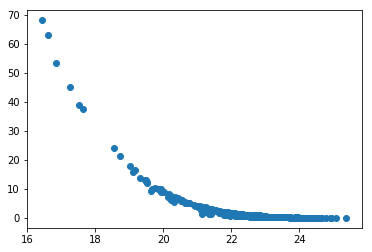

In [46]:
plt.clf()
ax=plt.gca()
#
ax.scatter(mags[gd_mag], np.array(s2n_dict['MEDIAN_SNR'])[gd_mag])
#
plt.show()

### Residual

In [47]:
exptime = qa_data['20200316'][21]['b1']['S2N']['METRICS']['EXPTIME']
exptime

1068.323891763128

In [48]:
r2= qa_data['20200316'][21]['b1']['S2N']['METRICS']['r2']
funcMap={"linear":lambda x,a,b:a+b*x,
         "poly":lambda x,a,b,c:a+b*x+c*x**2,
         "astro":lambda x,a,b:(exptime*a*x)/np.sqrt(exptime*(a*x+b)+r2)
        }

In [49]:
fitfunc = funcMap['astro']

In [50]:
sci_idx = qa_data['20200316'][21]['b1']['S2N']['METRICS']['OBJLIST'].index('SCIENCE')
sci_idx

1

In [51]:
coeff = qa_data['20200316'][21]['b1']['S2N']['METRICS']['FITCOEFF_TGT'][sci_idx]
coeff

[0.027920630277685786, 0.8959399437876857]

In [52]:
x=10**(-0.4*(mags[gd_mag]-22.5))
fit_snr = fitfunc(x,  *coeff)
fit_snr[0:50]

array([  1.36449268,   0.9580083 ,   0.49074507,   1.58964662,
         1.23948935,   1.46922808,   0.51464714,   1.36268794,
         3.40069131,   1.68523276,   0.21255154,   1.27535618,
         9.58362439,   0.60623295,   0.79591003,   2.83980912,
         0.25483681,  11.25788294,   0.10257219,   1.09204645,
         6.26164048,   0.65943473,   0.14028776,   0.37525037,
         0.51442751,   6.96279364,   0.78569922,   0.65721245,
         0.93645867,   1.63255776,   0.77769827,   0.25840684,
         0.39714861,   0.4618088 ,   0.81998684,   3.09832851,
         1.16616694,   0.50508932,   0.33451437,   0.35872628,
         0.48271111,   0.88997295,   0.62747205,   2.07012632,
         1.0842561 ,   0.1579618 ,   0.46804758,   0.30877986,
         0.81128666,   0.33791508])

In [53]:
r2

0.0

In [54]:
resid = (np.array(s2n_dict['MEDIAN_SNR'])[gd_mag]-fit_snr)/fit_snr

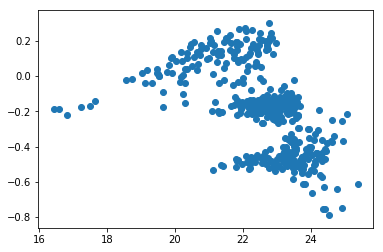

In [55]:
plt.clf()
ax=plt.gca()
#
ax.scatter(mags[gd_mag], resid)
#
plt.show()

### With fit

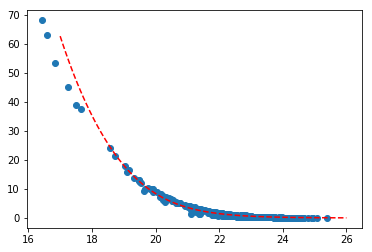

In [56]:
plt.clf()
ax=plt.gca()
#
ax.scatter(mags[gd_mag], np.array(s2n_dict['MEDIAN_SNR'])[gd_mag])
# Fit
xmag = np.linspace(17., 26., 100)
xval=10**(-0.4*(xmag-22.5))
yval = fitfunc(xval, *coeff)
ax.plot(xmag, yval, '--r')
#
#ax.set_ylim(5., 20.)
#
plt.show()

#### Note the points at very bright values are likely stars

----

In [22]:
np.array(s2n_dict['MAGNITUDES']).size

1500

In [21]:
np.array(s2n_dict['MEDIAN_SNR']).size

500